In [0]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime 
from datetime import timedelta
import seaborn as sns
from sklearn import linear_model
%matplotlib inline

# Intractive Plotly Viz
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

#Data input

In [0]:
#check the old format
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = deaths.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

df = confirmed_table.merge(death_table).merge(recovered_table)

df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,2020-01-22,0,0,0
1,,Albania,2020-01-22,0,0,0
2,,Algeria,2020-01-22,0,0,0
3,,Andorra,2020-01-22,0,0,0
4,,Angola,2020-01-22,0,0,0


In [0]:
owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
owid['date'] = pd.to_datetime(owid['date'])
owid.fillna('', inplace=True)

In [0]:
def get_info(countries):
    pop = owid.loc[(owid['location'] == countries) & (owid['date'] == owid['date'].max()), 'population_density']
    med = owid.loc[(owid['location'] == countries) & (owid['date'] == owid['date'].max()), 'median_age']    
    gdp = owid.loc[(owid['location'] == countries) & (owid['date'] == owid['date'].max()), 'gdp_per_capita']
    bed = owid.loc[(owid['location'] == countries) & (owid['date'] == owid['date'].max()), 'hospital_beds_per_100k']
    print('population density: '+ str(pop))
    print('Median Age: '+ str(med))
    print('GDP per capita: '+ str(gdp))
    print('Hospital Bed: '+ str(bed))


In [0]:
get_info('Saudi Arabia')

population density: 16877   15.322000
Name: population_density, dtype: object
Median Age: 16877   31.900000
Name: median_age, dtype: object
GDP per capita: 16877   49045.411000
Name: gdp_per_capita, dtype: object
Hospital Bed: 16877   2.700000
Name: hospital_beds_per_100k, dtype: object


## Exploring for Saudi Arabia based on the current data

In [0]:
#Extracting Saudi Arabia's data 
covid_saudi=df[df['Country/Region']=="Saudi Arabia"]

#Extracting other countries for comparison of worst affected countries
covid_spain=df[df['Country/Region']=="Spain"]
covid_us=df[df['Country/Region']=="US"]
covid_italy=df[df['Country/Region']=="Italy"]
covid_iran=df[df['Country/Region']=="Iran"]
covid_france=df[df['Country/Region']=="France"]
covid_uk=df[df['Country/Region']=="UK"]
covid_br=df[df['Country/Region']=="Brazil"]

In [0]:
#Converting the date into Datetime format
covid_saudi["Date"]=pd.to_datetime(covid_saudi["Date"])
covid_spain["Date"]=pd.to_datetime(covid_spain["Date"])
covid_us["Date"]=pd.to_datetime(covid_us["Date"])
covid_italy["Date"]=pd.to_datetime(covid_italy["Date"])
covid_iran["Date"]=pd.to_datetime(covid_iran["Date"])
covid_france["Date"]=pd.to_datetime(covid_france["Date"])
covid_uk["Date"]=pd.to_datetime(covid_uk["Date"])
covid_br["Date"]=pd.to_datetime(covid_br["Date"])

In [0]:
#Grouping the data based on the Date 
saudi_datewise=covid_saudi.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
spain_datewise=covid_spain.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
us_datewise=covid_us.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
italy_datewise=covid_italy.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
iran_datewise=covid_iran.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
france_datewise=covid_france.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
uk_datewise=covid_uk.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
brazil_datewise=covid_br.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [0]:
saudi_datewise["Days Since"]=(saudi_datewise.index-saudi_datewise.index[0])
saudi_datewise["Days Since"]=saudi_datewise["Days Since"].dt.days

In [0]:
#Adding week column to perfom weekly analysis further ahead
saudi_datewise["WeekofYear"]=saudi_datewise.index.weekofyear
spain_datewise["WeekofYear"]=spain_datewise.index.weekofyear
us_datewise["WeekofYear"]=us_datewise.index.weekofyear
italy_datewise["WeekofYear"]=italy_datewise.index.weekofyear
iran_datewise["WeekofYear"]=iran_datewise.index.weekofyear
france_datewise["WeekofYear"]=france_datewise.index.weekofyear
uk_datewise["WeekofYear"]=uk_datewise.index.weekofyear
brazil_datewise["WeekofYear"]=brazil_datewise.index.weekofyear

In [0]:
df["Date"]=pd.to_datetime(df["Date"])
grouped_country=df.groupby(["Country/Region","Date"]).agg({"Confirmed":'sum',
                                                                         "Recovered":'sum',"Deaths":'sum'})

In [0]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [0]:
print("Number of Confirmed Cases",saudi_datewise["Confirmed"].iloc[-1])
print("Number of Recovered Cases",saudi_datewise["Recovered"].iloc[-1])
print("Number of Death Cases",saudi_datewise["Deaths"].iloc[-1])
print("Number of Active Cases",saudi_datewise["Confirmed"].iloc[-1]-saudi_datewise["Recovered"].iloc[-1]-saudi_datewise["Deaths"].iloc[-1])
print("Number of Closed Cases",saudi_datewise["Recovered"].iloc[-1]+saudi_datewise["Deaths"].iloc[-1])
print("Approximate Number of Confirmed Cases per day",round(saudi_datewise["Confirmed"].iloc[-1]/saudi_datewise.shape[0]))
print("Approximate Number of Recovered Cases per day",round(saudi_datewise["Recovered"].iloc[-1]/saudi_datewise.shape[0]))
print("Approximate Number of Death Cases per day",round(saudi_datewise["Deaths"].iloc[-1]/saudi_datewise.shape[0]))
print("Number of New Cofirmed Cases in last 24 hours are",saudi_datewise["Confirmed"].iloc[-1]-saudi_datewise["Confirmed"].iloc[-2])
print("Number of New Recoverd Cases in last 24 hours are",saudi_datewise["Recovered"].iloc[-1]-saudi_datewise["Recovered"].iloc[-2])
print("Number of New Death Cases in last 24 hours are",saudi_datewise["Deaths"].iloc[-1]-saudi_datewise["Deaths"].iloc[-2])

Number of Confirmed Cases 83384
Number of Recovered Cases 58883
Number of Death Cases 480
Number of Active Cases 24021
Number of Closed Cases 59363
Approximate Number of Confirmed Cases per day 641.0
Approximate Number of Recovered Cases per day 453.0
Approximate Number of Death Cases per day 4.0
Number of New Cofirmed Cases in last 24 hours are 1618
Number of New Recoverd Cases in last 24 hours are 1870
Number of New Death Cases in last 24 hours are 22


Active Cases = Number of Confirmed Cases - Number of Recovered Cases - Number of Death Cases

In [0]:
fig=px.bar(x=saudi_datewise.index,y=saudi_datewise["Confirmed"]-saudi_datewise["Recovered"]-saudi_datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [0]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in Saudi Arabia",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [0]:
print('Mean Recovery Rate: ',((saudi_datewise["Recovered"]/saudi_datewise["Confirmed"])*100).mean())
print('Mean Mortality Rate: ',((saudi_datewise["Deaths"]/saudi_datewise["Confirmed"])*100).mean())
print('Median Recovery Rate: ',((saudi_datewise["Recovered"]/saudi_datewise["Confirmed"])*100).median())
print('Median Mortality Rate: ',((saudi_datewise["Deaths"]/saudi_datewise["Confirmed"])*100).median())

fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=saudi_datewise.index, y=(saudi_datewise["Recovered"]/saudi_datewise["Confirmed"])*100,
              name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=saudi_datewise.index, y=(saudi_datewise["Deaths"]/saudi_datewise["Confirmed"])*100,
              name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Mean Recovery Rate:  20.475884185513372
Mean Mortality Rate:  0.6040704531085832
Median Recovery Rate:  15.118791238974847
Median Mortality Rate:  0.6063889152753927


Mortality rate = (Number of Death Cases / Number of Confirmed Cases) x 100

Recovery Rate= (Number of Recoverd Cases / Number of Confirmed Cases) x 100


Growth Factor for different types of Cases¶

Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

Formula: Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.

A growth factor above 1 indicates an increase correspoding cases.

A growth factor above 1 but trending downward is a positive sign, whereas a growth factor constantly above 1 is the sign of exponential growth.

A growth factor constant at 1 indicates there is no change in any kind of cases.


In [0]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Confirmed"]/saudi_datewise["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Recovered"]/saudi_datewise["Recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Deaths"]/saudi_datewise["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases in Saudi Arabia",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [0]:
week_num_saudi=[]
saudi_weekwise_confirmed=[]
saudi_weekwise_recovered=[]
saudi_weekwise_deaths=[]
w=1
for i in list(saudi_datewise["WeekofYear"].unique()):
    saudi_weekwise_confirmed.append(saudi_datewise[saudi_datewise["WeekofYear"]==i]["Confirmed"].iloc[-1])
    saudi_weekwise_recovered.append(saudi_datewise[saudi_datewise["WeekofYear"]==i]["Recovered"].iloc[-1])
    saudi_weekwise_deaths.append(saudi_datewise[saudi_datewise["WeekofYear"]==i]["Deaths"].iloc[-1])
    week_num_saudi.append(w)
    w=w+1



In [0]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num_saudi, y=saudi_weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num_saudi, y=saudi_weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num_saudi, y=saudi_weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in Saudi",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [0]:
print("Average weekly increase in number of Confirmed Cases",round(pd.Series(saudi_weekwise_confirmed).diff().fillna(0).mean()))
print("Average weekly increase in number of Recovered Cases",round(pd.Series(saudi_weekwise_recovered).diff().fillna(0).mean()))
print("Average weekly increase in number of Death Cases",round(pd.Series(saudi_weekwise_deaths).diff().fillna(0).mean()))

fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Bar(x=week_num_saudi, y=pd.Series(saudi_weekwise_confirmed).diff().fillna(0),
          name="Weekly rise in number of Confirmed Cases"),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=week_num_saudi, y=pd.Series(saudi_weekwise_deaths).diff().fillna(0),
          name="Weekly rise in number of Death Cases"),
    row=1, col=2
)
fig.update_layout(title="Saudi Arabia's Weekly increas in Number of Confirmed and Death Cases",
    font=dict(
        size=10,
    )
)
fig.update_layout(width=800,legend=dict(x=0,y=-0.5,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Number of Cases", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Number of Cases", row=1, col=2)
fig.show()

Average weekly increase in number of Confirmed Cases 4389
Average weekly increase in number of Recovered Cases 3099
Average weekly increase in number of Death Cases 25


In [0]:
cases=65
double_days=[]
C=[]
while(1):
    double_days.append(int(saudi_datewise[saudi_datewise["Confirmed"]<=cases].iloc[[-1]]["Days Since"]))
    C.append(cases)
    cases=cases*2
    if(cases<saudi_datewise["Confirmed"].max()):
        continue
    else:
        break
        
cases=65
tipling_days=[]
C1=[]
while(1):
    tipling_days.append(int(saudi_datewise[saudi_datewise["Confirmed"]<=cases].iloc[[-1]]["Days Since"]))
    C1.append(cases)
    cases=cases*3
    if(cases<saudi_datewise["Confirmed"].max()):
        continue
    else:
        break
        
saudi_doubling=pd.DataFrame(list(zip(C,double_days)),columns=["No. of cases","Days since first case"])
saudi_doubling["Number of days required to Double the cases"]=saudi_doubling["Days since first case"].diff().fillna(saudi_doubling["Days since first case"].iloc[0])

saudi_tripling=pd.DataFrame(list(zip(C1,tipling_days)),columns=["No. of cases","Days since first case"])
saudi_tripling["Number of days required to Triple the cases"]=saudi_tripling["Days since first case"].diff().fillna(saudi_tripling["Days since first case"].iloc[0])

saudi_doubling.style.background_gradient(cmap='Reds')

,No. of cases,Days since first case,Number of days required to Double the cases
0,65,50,50.000000
1,130,54,4.000000
2,260,56,2.000000
3,520,60,4.000000
4,1040,64,4.000000
5,2080,72,8.000000
6,4160,80,8.000000
7,8320,87,7.000000
8,16640,94,7.000000
9,33280,105,11.000000


In [0]:
#Tripling Rate of COVID-19 Confirmed Cases
saudi_tripling.style.background_gradient(cmap='Reds')

,No. of cases,Days since first case,Number of days required to Triple the cases
0,65,50,50.000000
1,195,56,6.000000
2,585,61,5.000000
3,1755,70,9.000000
4,5265,82,12.000000
5,15795,93,11.000000
6,47385,113,20.000000


Comparison of Saudi Arabia with other Countries

In [0]:
#Adding week column to perfom weekly analysis further ahead
saudi_datewise["WeekofYear"]=saudi_datewise.index.weekofyear
spain_datewise["WeekofYear"]=spain_datewise.index.weekofyear
us_datewise["WeekofYear"]=us_datewise.index.weekofyear
italy_datewise["WeekofYear"]=italy_datewise.index.weekofyear
iran_datewise["WeekofYear"]=iran_datewise.index.weekofyear
france_datewise["WeekofYear"]=france_datewise.index.weekofyear
uk_datewise["WeekofYear"]=uk_datewise.index.weekofyear
brazil_datewise["WeekofYear"]=brazil_datewise.index.weekofyear

In [0]:
comp_data=pd.concat([saudi_datewise.iloc[[-1]],spain_datewise.iloc[[-1]],us_datewise.iloc[[-1]],
                     italy_datewise.iloc[[-1]],iran_datewise.iloc[[-1]],
                     ])
n_countries=["Saudi Arabia","Spain","US","Italy","Iran"]
comp_data.drop(["Days Since","WeekofYear"],1,inplace=True)
comp_data.index=n_countries
comp_data["Mortality"]=(comp_data["Deaths"]/comp_data["Confirmed"])*100
comp_data["Recovery"]=(comp_data["Recovered"]/comp_data["Confirmed"])*100
comp_data["Survival Probability"]=(1-(comp_data["Deaths"]/comp_data["Confirmed"]))*100
comp_data.sort_values(["Confirmed"],ascending=False)
comp_data.style.background_gradient(cmap='Reds')

,Confirmed,Recovered,Deaths,Mortality,Recovery,Survival Probability
Saudi Arabia,83384,58883,480,0.575650,70.616665,99.424350
Spain,239228,150376,27125,11.338556,62.858863,88.661444
US,1770165,416461,103776,5.862504,23.526677,94.137496
Italy,232664,155633,33340,14.329677,66.891741,85.670323
Iran,148950,116827,7734,5.192346,78.433703,94.807654


Saudi Arabia has the highest survival probability among other countries

In [0]:
fig=go.Figure()
for country in n_countries:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index, y=grouped_country.loc[country]["Confirmed"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(title="7 Days Rolling Average of Daily increase of Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()



In [0]:
pd.set_option('float_format', '{:f}'.format)
country_names=["Spain","US","Italy","Iran","Brazil","Saudi Arabia"]

country_data=pd.concat([spain_datewise.iloc[[-1]],us_datewise.iloc[[-1]],
                        italy_datewise.iloc[[-1]],iran_datewise.iloc[[-1]],
                        brazil_datewise.iloc[[-1]],saudi_datewise.iloc[[-1]]])
country_data=country_data.drop(["Days Since","WeekofYear"],1)
country_data["Mortality"]=(country_data["Deaths"]/country_data["Confirmed"])*100
country_data["Recovery"]=(country_data["Recovered"]/country_data["Confirmed"])*100
country_data.index=country_names
country_data.style.background_gradient(cmap='Blues').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery
Spain,239228.00,150376.00,27125.00,11.34,62.86
US,1770165.00,416461.00,103776.00,5.86,23.53
Italy,232664.00,155633.00,33340.00,14.33,66.89
Iran,148950.00,116827.00,7734.00,5.19,78.43
Brazil,498440.00,200892.00,28834.00,5.78,40.30
Saudi Arabia,83384.00,58883.00,480.00,0.58,70.62


In [0]:
ac_median_age=[45.5,38.3,47.9,32.4,33.5,31.9]
ac_bed=[2.9,2.7,3.1,1.5,2.2,2.7]
ac_gdp=[34272,54225,35220,19082,14103,49045]
ac_pd=[93,35,205,49,25,15]
country_data["Median Age"]=ac_median_age
country_data["Hospital Bed"]=ac_bed
country_data["GDP"]=ac_gdp
country_data["Population Density (per sq km)"]=ac_pd
country_data.sort_values(["Confirmed"],ascending=False)
country_data.style.background_gradient(cmap='Reds').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery,Median Age,Hospital Bed,GDP,Population Density (per sq km)
Spain,239228.00,150376.00,27125.00,11.34,62.86,45.50,2.90,34272.00,93.00
US,1770165.00,416461.00,103776.00,5.86,23.53,38.30,2.70,54225.00,35.00
Italy,232664.00,155633.00,33340.00,14.33,66.89,47.90,3.10,35220.00,205.00
Iran,148950.00,116827.00,7734.00,5.19,78.43,32.40,1.50,19082.00,49.00
Brazil,498440.00,200892.00,28834.00,5.78,40.30,33.50,2.20,14103.00,25.00
Saudi Arabia,83384.00,58883.00,480.00,0.58,70.62,31.90,2.70,49045.00,15.00


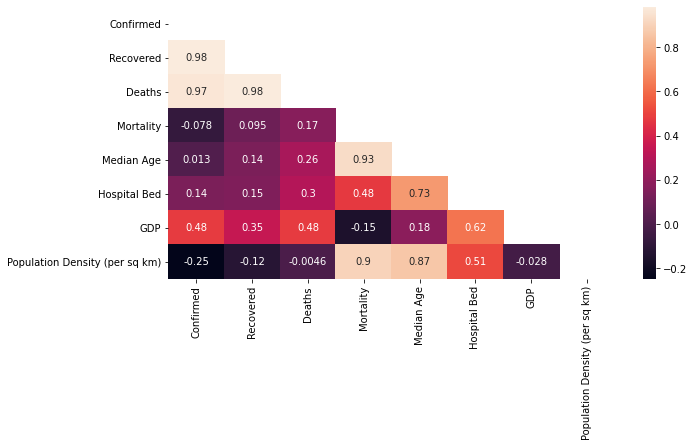

In [0]:
new_req=country_data[["Confirmed","Recovered","Deaths","Mortality","Median Age","Hospital Bed",
                     "GDP","Population Density (per sq km)"]]
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(new_req.corr(), dtype=np.bool))
sns.heatmap(new_req.corr(),annot=True, mask=mask)

Popilation Density and Median Age's has correlation with number of Confirmed Cases.

In [0]:
fig=go.Figure()
for country in country_names:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country]["log_confirmed"], y=grouped_country.loc[country]["log_active"],
                    mode='lines',name=country))
fig.update_layout(height=600,title="COVID-19 Journey of some worst affected countries and Saudi Arabia",
                 xaxis_title="Confirmed Cases (Logrithmic Scale)",yaxis_title="Active Cases (Logarithmic Scale)",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# Machine Learning Predictions

In [0]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from fbprophet import Prophet

Polynomial Regression

In [0]:
train_ml=saudi_datewise.iloc[:int(saudi_datewise.shape[0]*0.95)]
valid_ml=saudi_datewise.iloc[int(saudi_datewise.shape[0]*0.95):]
model_scores=[]

In [0]:
poly = PolynomialFeatures(degree = 6)

In [0]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [0]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly) 

Root Mean Squared Error for Polynomial Regression:  2793.849610433086


In [0]:
comp_data=poly.fit_transform(np.array(saudi_datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)
fig=go.Figure()
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [0]:
new_date=[]
new_prediction_poly=[]
for i in range(1,18):
    new_date.append(saudi_datewise.index[-1]+timedelta(days=i))
    new_date_poly=poly.fit_transform(np.array(saudi_datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [0]:
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly),columns=["Date","Polynomial Regression Prediction"])
model_predictions.head()

,Date,Polynomial Regression Prediction
0,2020-05-31,91045.685613
1,2020-06-01,93656.440629
2,2020-06-02,96236.651485
3,2020-06-03,98778.264432
4,2020-06-04,101272.780007


Support Vector Machine Regressor

In [0]:
train_ml=saudi_datewise.iloc[:int(saudi_datewise.shape[0]*0.95)]
valid_ml=saudi_datewise.iloc[int(saudi_datewise.shape[0]*0.95):]

In [0]:
svm=SVR(kernel='poly',C=0.01,degree=6)

In [0]:
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),train_ml["Confirmed"])

SVR(C=0.01, cache_size=200, coef0=0.0, degree=6, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
prediction_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
rmse_svm=np.sqrt(mean_squared_error(prediction_svm,valid_ml["Confirmed"]))
model_scores.append(rmse_svm)
print("Root Mean Square Error for SVR Model: ",rmse_svm)

Root Mean Square Error for SVR Model:  12771.459524531425


In [0]:
plt.figure(figsize=(11,6))
predictions=svm.predict(np.array(saudi_datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=saudi_datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=saudi_datewise.index, y=predictions,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [0]:
new_date=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(saudi_datewise.index[-1]+timedelta(days=i))
    new_prediction_svm.append(svm.predict(np.array(saudi_datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [0]:
model_predictions["SVM Prediction"]=new_prediction_svm
model_predictions.head()

,Date,Polynomial Regression Prediction,SVM Prediction
0,2020-05-31,91045.685613,108188.784898
1,2020-06-01,93656.440629,113281.073635
2,2020-06-02,96236.651485,118571.478442
3,2020-06-03,98778.264432,124066.118105
4,2020-06-04,101272.780007,129771.252064


Time Series Forecasting Models

Holt's Linear Model

In [0]:
model_train=saudi_datewise.iloc[:int(saudi_datewise.shape[0]*0.95)]
valid=saudi_datewise.iloc[int(saudi_datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [0]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.2, smoothing_slope=2.0)

In [0]:
y_pred["Holt"]=holt.forecast(len(valid))
rmse_holt_linear=np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"]))
model_scores.append(rmse_holt_linear)
print("Root Mean Square Error Holt's Linear Model: ",rmse_holt_linear)

Root Mean Square Error Holt's Linear Model:  1455.501655307507


In [0]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [0]:
holt_new_prediction=[]
for i in range(1,18):
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Date,Polynomial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2020-05-31,91045.685613,108188.784898,88376.207602
1,2020-06-01,93656.440629,113281.073635,90628.767384
2,2020-06-02,96236.651485,118571.478442,92881.327166
3,2020-06-03,98778.264432,124066.118105,95133.886947
4,2020-06-04,101272.780007,129771.252064,97386.446729


In [0]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(saudi_datewise.index),list(saudi_datewise["Confirmed"])),columns=['ds','y'])


In [0]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [0]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [0]:
model_scores.append(np.sqrt(mean_squared_error(saudi_datewise["Confirmed"],confirmed_forecast['yhat'].head(saudi_datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(saudi_datewise["Confirmed"],confirmed_forecast['yhat'].head(saudi_datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  564.7148814503457


Figure(720x432)


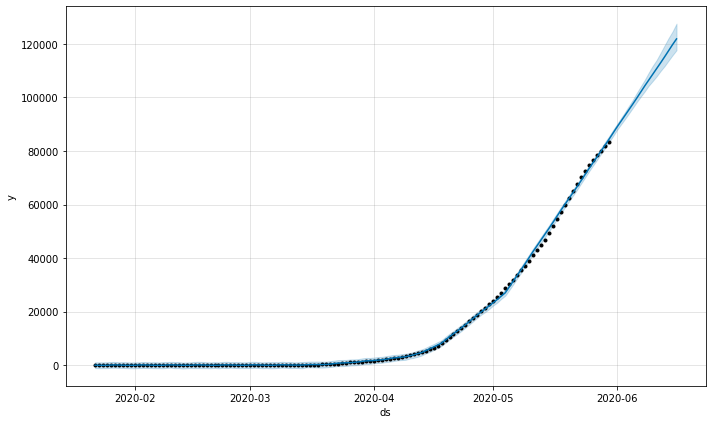

In [0]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


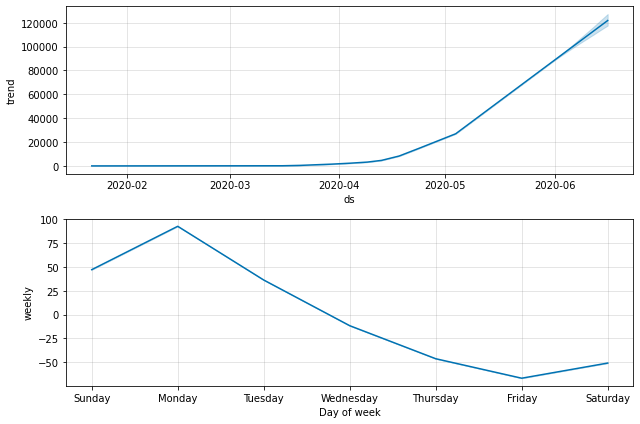

In [0]:
print(prophet_c.plot_components(confirmed_forecast))

In [0]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
model_predictions.head()

,Date,Polynomial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2020-05-31,91045.685613,108188.784898,88376.207602,86572.566334,87674.358339
1,2020-06-01,93656.440629,113281.073635,90628.767384,88825.398995,89903.787502
2,2020-06-02,96236.651485,118571.478442,92881.327166,90976.197976,92162.076541
3,2020-06-03,98778.264432,124066.118105,95133.886947,93135.444303,94395.084554
4,2020-06-04,101272.780007,129771.252064,97386.446729,95307.982951,96746.183817


In [0]:
models=["Polynomial Regression","Support Vector Machine Regresssor","Holt's Linear Model",
       "Facebook's Prophet Model"]

In [0]:
model_evaluation=pd.DataFrame(list(zip(models,model_scores)),columns=["Model Name","Root Mean Squared Error"])
model_evaluation=model_evaluation.sort_values(["Root Mean Squared Error"])
model_evaluation.style.background_gradient(cmap='Reds')

,Model Name,Root Mean Squared Error
3,Facebook's Prophet Model,564.714881
2,Holt's Linear Model,1455.501655
0,Polynomial Regression,2793.849610
1,Support Vector Machine Regresssor,12771.459525


In [0]:
model_predictions["Average of Predictions Models"]=model_predictions.mean(axis=1)
show_predictions=model_predictions.head()
show_predictions

,Date,Polynomial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Average of Predictions Models
0,2020-05-31,91045.685613,108188.784898,88376.207602,86572.566334,87674.358339,92371.520557
1,2020-06-01,93656.440629,113281.073635,90628.767384,88825.398995,89903.787502,95259.093629
2,2020-06-02,96236.651485,118571.478442,92881.327166,90976.197976,92162.076541,98165.546322
3,2020-06-03,98778.264432,124066.118105,95133.886947,93135.444303,94395.084554,101101.759668
4,2020-06-04,101272.780007,129771.252064,97386.446729,95307.982951,96746.183817,104096.929114
